In [1]:
# import some keras and basic module 

from __future__ import print_function 
import tensorflow.keras as keras

# data set cifar 10 
from tensorflow.keras.datasets import cifar10 

# basic preprocesssing for image data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# construct neural network 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os 

import numpy as np 

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
import tensorflow as tf 

# config = tf.ConfigProto()
# tf.enable_eager_execution(config=config)

from fmp import *

In [2]:

## basic parameters 
batch_size = 40 
num_classes = 10 
num_epochs = 300 
is_data_augmentation = True 
model_dir = 'models'
model_filename = 'model_BeatLeNet5_4_BatchNormalization.h'


In [3]:
#read data and split data into train and test set

(train_set,train_label),(test_set,test_label) = cifar10.load_data() 

print('the shape of training data set is: ',train_set.shape) 


the shape of training data set is:  (50000, 32, 32, 3)


In [4]:
# Convert class label to binary vector 
train_label = keras.utils.to_categorical(train_label,num_classes)
test_label  = keras.utils.to_categorical(test_label,num_classes) 
print(train_label.shape)
print(test_label.shape)

(50000, 10)
(10000, 10)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


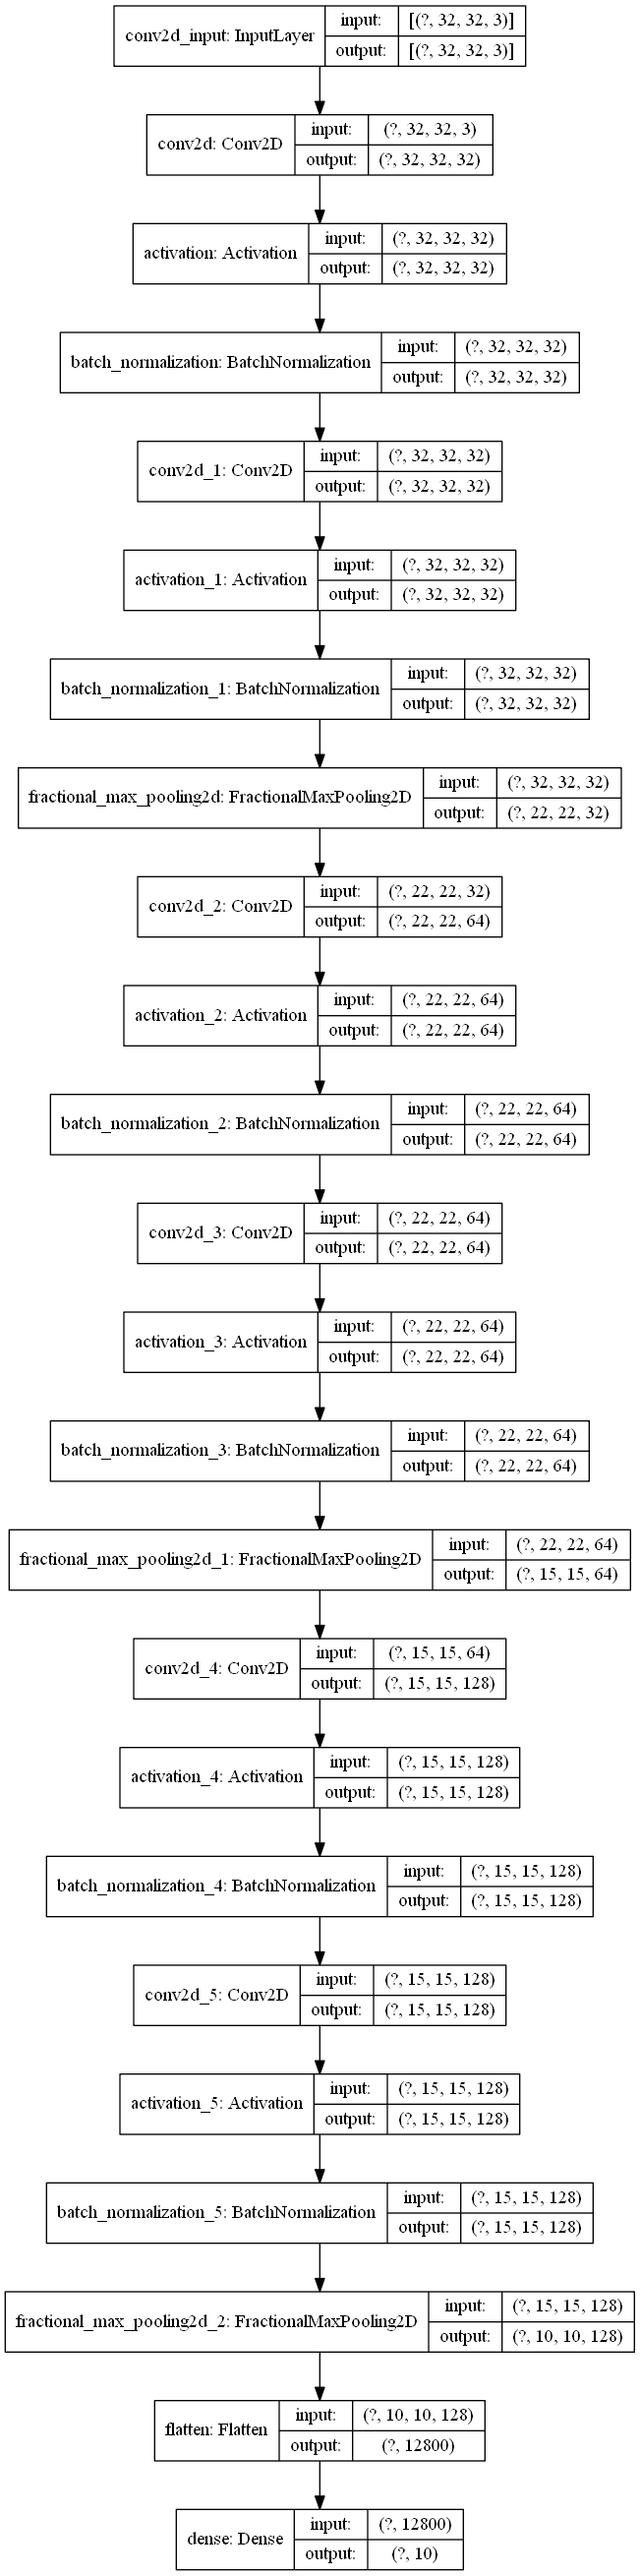

In [5]:
# construct the model 

cnn_model = Sequential() 


weight_decay = 1e-4
cnn_model.add(Conv2D(32,(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                     ,input_shape=train_set.shape[1:] ))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32,(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay) ))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(FractionalMaxPooling2D(pooling_ratio = [1.414,1.414]))



cnn_model.add(Conv2D(64,(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64,(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(FractionalMaxPooling2D(pooling_ratio = [1.414,1.414]))


# as the last layer is not 
# add dropout layer 


cnn_model.add(Conv2D(128,(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay) ))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128,(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(FractionalMaxPooling2D(pooling_ratio = [1.414,1.414]))






cnn_model.add(Flatten())


# full connected layer nfilters = 120 






# last full connected layer nfilters = 10 
cnn_model.add(Dense(10 , activation = 'softmax'))
plot_model(cnn_model, show_shapes=True,to_file='cnn_model.png')


In [ ]:


# initialization of optimizer 
opt = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# train the model by optimizer
cnn_model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

train_set = train_set.astype('float32')
test_set = test_set.astype('float32') 

train_set /= 255 
test_set /= 255 

if not is_data_augmentation:
    print('Not using data augmentation.')
    cnn_history = cnn_model.fit(train_set, train_label,
              batch_size=batch_size,
              epochs=num_epochs,
              validation_data=(test_set, test_label),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
     
    
    # set parameter for data augmentation 
    data_transform_parameters = {
                                "rotation_range": 15,
                                "width_shift_range":0.1,
                                "height_shift_range":0.1,
                                "horizontal_flip":True
                                }
    
    # get object of augmentation data generator 
    augment_data_set_generator = ImageDataGenerator(data_transform_parameters)    
    
    
    # get augmented data set 
    
    augment_train_set = augment_data_set_generator.apply_transform(train_set,data_transform_parameters)
    print(augment_train_set.shape)
  
    
    # Limit GPU device to the first GPU 
    #gpus = tf.config.experimental.list_physical_devices('GPU')
    #if gpus:
      # Restrict TensorFlow to only use the first GPU
    #  try:
    #    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    #    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    #    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    #  except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
    #    print(e)
        
        
    # train model by GPU 
   # with tf.device('/device:GPU:0'):
    cnn_history = cnn_model.fit(augment_train_set, train_label,
              batch_size=batch_size,
              epochs=num_epochs,
              validation_data=(test_set, test_label),
              shuffle=True)

# save model and weights 
if not os.path.isdir(model_dir): 
    os.makedirs(model_dir) 
model_path = os.path.join(model_dir,model_filename)
cnn_model.save(model_path)
print("CNN Model saved at %s " % model_path)

# Score trained model 

test_loss_value, test_metric_value = cnn_model.evaluate(test_set,test_label,verbose =1 )
train_loss_value, train_metric_value = cnn_model.evaluate(train_set,train_label,verbose =1)


print("Train loss: ", train_loss_value) 
print("Trian metric: ", train_metric_value)

print("Test loss: ", test_loss_value)
print("Test accuracy:", test_metric_value)
# print(cnn_history.history)


Using real-time data augmentation.
(50000, 32, 32, 3)
Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  36/1250 [..............................] - ETA: 5:45 - loss: 6.7001 - accuracy: 0.2201

In [ ]:

# get history data
epoth_x = np.linspace(0, 10, num_epochs, endpoint=True)
train_loss = cnn_history.history['loss']
train_accuracy = cnn_history.history['acc']
test_loss = cnn_history.history['val_loss']
test_accuracy = cnn_history.history['val_acc']

# plot train loss and accuracy
plt.figure() 
plt.plot(epoth_x, train_loss,label = 'train loss')
plt.plot(epoth_x,train_accuracy,label = 'train accuracy')
plt.title("train loss and train accuracy")
plt.legend()


# plot test loss and accuracy
plt.figure() 
plt.plot(epoth_x, test_loss, label = 'test loss')
plt.plot(epoth_x,test_accuracy, label = 'test accuracy')
plt.legend()
plt.title("test loss and test accuracy")